In [177]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import os, re
import tensorflow_hub as hub
import tensorflow as tf
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

[nltk_data] Downloading package stopwords to /Users/oanh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/oanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [178]:
data = pd.read_csv('Dataset_Suicide.csv', lineterminator = '\n')
data

,Unnamed: 0,Post,Suicidal_label,Sentiment_label
0,0,Ex Wife Threatening SuicideRecently I left my ...,0,0
1,1,Am I weird I don t get affected by compliments...,1,1
2,2,Finally is almost over So I can never hear ...,1,0
3,3,i need helpjust help me im crying so hard,0,0
4,4,I m so lostHello my name is Adam and I ve b...,0,0
...,...,...,...,...
226948,227680,I sound like a dudebro but I can t handle my f...,0,0
226949,227681,Fuck my sister She is such I fucking bitch and...,1,0
226950,227682,I ve been suicidal for years and no one knowsT...,0,1
226951,227683,My boyfriend is sick so I took some Polaroids ...,1,0


In [179]:
import pandas as pd

# Assuming you have a DataFrame 'df' with the 'label' column
data['Suicidal_label'] = data['Suicidal_label'].map({1: 0, 0: 1})
data['Sentiment_label'] = data['Sentiment_label'].map({1: 2, 0: 1, 2: 0})
data.head()

,Unnamed: 0,Post,Suicidal_label,Sentiment_label
0,0,Ex Wife Threatening SuicideRecently I left my ...,1,1
1,1,Am I weird I don t get affected by compliments...,0,2
2,2,Finally is almost over So I can never hear ...,0,1
3,3,i need helpjust help me im crying so hard,1,1
4,4,I m so lostHello my name is Adam and I ve b...,1,1


In [180]:
print(data.shape)
data['Suicidal_label'].value_counts()

(226953, 4)


1    113534
0    113419
Name: Suicidal_label, dtype: int64

In [181]:
data['Post'].fillna('default_text', inplace=True)
def preprocess(string):
    phrase = str(string)
    phrase = re.sub('[^a-z]+', ' ', phrase, flags = re.IGNORECASE)
    phrase = re.sub('(\s+)', ' ', phrase)
    phrase = re.sub('http\S+', ' ', phrase)
    phrase = phrase.lower()
    words_li = ['filler']
    li = list(stopwords.words()) + words_li
    text_tokens = word_tokenize(phrase)
    return " ".join([word for word in text_tokens if word not in li])
print(data['Post'].apply(lambda x: len(x.split(' '))).sum())

34592572


In [182]:
data['Post'] = data['Post'].map(lambda string: preprocess(string))
print(data['Post'].apply(lambda x: len(x.split(' '))).sum())

9211270


In [183]:
print(data.shape)
data['Suicidal_label'].value_counts()

(226953, 4)


1    113534
0    113419
Name: Suicidal_label, dtype: int64

In [184]:
X = data['Post'].values
y = data['Suicidal_label'].values

le = LabelEncoder()

y = le.fit_transform(y)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, stratify = y)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, train_size = 0.75, stratify = train_y)
print(train_X.shape, test_y.shape, val_X.shape)

(136171,) (45391,) (45391,)


In [185]:
import gensim
import gensim.downloader as api 
import numpy as np
import nltk

# Load FastText model (ensure you have FastText installed and the model is downloaded)
wv = api.load("fasttext-wiki-news-subwords-300")

In [186]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.get_vector(word))
            all_words.add(wv.key_to_index[word])

    if not mean:
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

In [187]:
def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(str(text), language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            word = word.lower()
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [188]:
# Process training data
X_bigtrain = np.concatenate((train_X,val_X))
y_bigtrain = np.concatenate((train_y, val_y))
train_X_tokenized = [w2v_tokenize_text(text) for text in X_bigtrain]
X_train_word_average = word_averaging_list(wv, train_X_tokenized)
# Process testing data
test_X_tokenized = [w2v_tokenize_text(text) for text in test_X]
X_test_word_average = word_averaging_list(wv, test_X_tokenized)

## **Choose Recursive Neural Network as the final model**
### **Use Recall as the metric**

In [195]:
import numpy as np
import gensim.downloader as api
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from keras.metrics import Recall
import matplotlib.pyplot as plt

# Assuming word embeddings size is 300 for FastText model
embedding_dimension = 300

# Initialize a list to store the cross-validation recall scores
cv_scores_recall = []

# Ensure that X_train_word_average has the correct shape
X_train_word_average = word_averaging_list(wv, train_X_tokenized)
X_train_word_average = np.array(X_train_word_average)
X_train_word_average = X_train_word_average.reshape(X_train_word_average.shape[0], embedding_dimension)

# Ensure that train_y has the correct shape
train_y = np.array(y_bigtrain)

# Ensure that X_train_word_average has the correct shape
X_test_word_average = word_averaging_list(wv, test_X_tokenized)
X_test_word_average = np.array(X_test_word_average)
X_test_word_average = X_test_word_average.reshape(X_test_word_average.shape[0], embedding_dimension)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Build the model
model = Sequential()
model.add(Dense(64, input_shape=(embedding_dimension,)))  # Assuming word embeddings size is 300 for FastText model
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, hence 1 neuron with sigmoid activation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Recall()])

# Initialize lists to store training and test recall over epochs
train_losses = []
val_losses = []
scores, histories = list(), list()

# Perform K-fold cross-validation
for train_index, test_index in kf.split(X_train_word_average):
    # Split data into training and test sets for this fold
    X_train_fold, X_test_fold = X_train_word_average[train_index], X_train_word_average[test_index]
    y_train_fold, y_test_fold = train_y[train_index], train_y[test_index]

    # Early stopping callback for each fold
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the model for this fold
    history = model.fit(X_train_fold, y_train_fold, batch_size=32, epochs=100,
                        verbose=1, callbacks=[early_stopping], validation_data=(X_test_fold, y_test_fold))

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Evaluate the model on the validation set for this fold
    _, acc = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    scores.append(acc)
    histories.append(history)
    
# Calculate and print the average cross-validation recall
average_cv_recall = np.mean(scores)
print(f'Cross-Validation Recall: {100 * average_cv_recall:.2f}%')

# Evaluate the model on the full training set
train_score = model.evaluate(X_train_word_average, train_y, verbose=0)
print('Training loss:', train_score[0])
print('Training recall:', train_score[1])

# Evaluate the model on the full test set
test_score = model.evaluate(X_test_word_average, test_y, verbose=0)
print('Test loss:', test_score[0])
print('Test recall:', test_score[1])

Epoch 1/100
4540/4540 [==============================] - 2s 423us/step - loss: 0.3227 - recall_24: 0.8963 - val_loss: 0.2703 - val_recall_24: 0.9029
Epoch 2/100
4540/4540 [==============================] - 2s 403us/step - loss: 0.2767 - recall_24: 0.9074 - val_loss: 0.2521 - val_recall_24: 0.9159
Epoch 3/100
4540/4540 [==============================] - 2s 407us/step - loss: 0.2641 - recall_24: 0.9094 - val_loss: 0.2505 - val_recall_24: 0.9302
Epoch 4/100
4540/4540 [==============================] - 2s 405us/step - loss: 0.2558 - recall_24: 0.9099 - val_loss: 0.2415 - val_recall_24: 0.9263
Epoch 5/100
4540/4540 [==============================] - 2s 407us/step - loss: 0.2511 - recall_24: 0.9096 - val_loss: 0.2436 - val_recall_24: 0.8858
Epoch 6/100
4540/4540 [==============================] - 2s 404us/step - loss: 0.2471 - recall_24: 0.9105 - val_loss: 0.2317 - val_recall_24: 0.9096
Epoch 7/100
4540/4540 [==============================] - 2s 406us/step - loss: 0.2438 - recall_24: 0.9124 

In [199]:
# Make predictions on the testing data
y_test_pred = model.predict(X_test_word_average)
y_test_pred = (y_test_pred > 0.5).astype(int)

# Print the accuracy and recall scores for the testing data
from sklearn.metrics import accuracy_score, recall_score, classification_report

# Print the classification report for the testing data
print("RNN")
print(classification_report(test_y, y_test_pred))

1419/1419 [==============================] - 0s 198us/step
RNN
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     22684
           1       0.91      0.93      0.92     22707

    accuracy                           0.92     45391
   macro avg       0.92      0.92      0.92     45391
weighted avg       0.92      0.92      0.92     45391



## **Learning Curves**

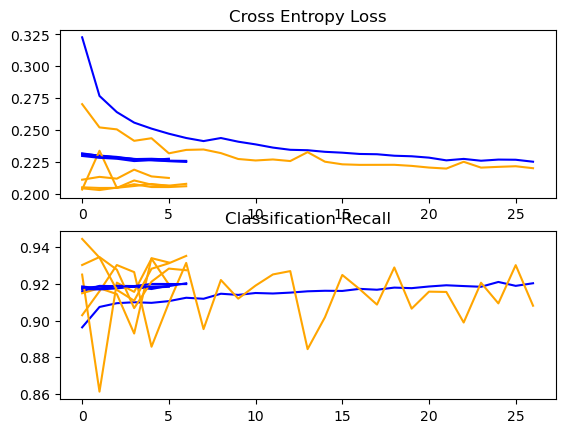

In [197]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Recall')
        plt.plot(histories[i].history['recall_24'], color='blue', label='train')
        plt.plot(histories[i].history['val_recall_24'], color='orange', label='test')
    plt.show()
summarize_diagnostics(histories)

## **Recall Scores Distribution**

Recall: mean=0.927 std=0.006, n=5


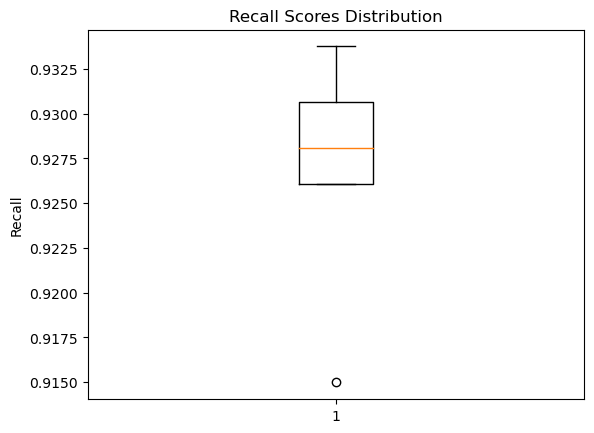

In [193]:
import matplotlib.pyplot as plt

# Call the summarize_performance function with your recall scores
def summarize_performance(scores):
    # Print summary
    print('Recall: mean=%.3f std=%.3f, n=%d' % (np.mean(scores), np.std(scores), len(scores)))
    # Box and whisker plots of results
    plt.boxplot(scores)
    plt.title('Recall Scores Distribution')
    plt.ylabel('Recall')
    plt.show()

# Call the summarize_performance function with your cross-validation recall scores
summarize_performance(scores)

## **Confusion Matrix**

<Axes: title={'center': 'Confusion Matrix for RNN'}, xlabel='Predicted label', ylabel='True label'>

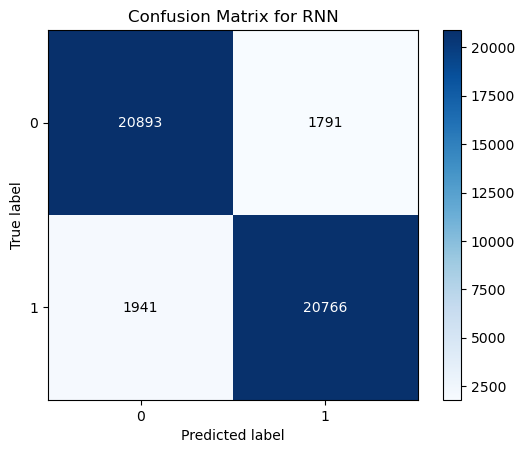

In [22]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(test_y, y_test_pred, normalize=False, title = 'Confusion Matrix for RNN')

<Axes: title={'center': 'Confusion Matrix for RNN'}, xlabel='Predicted label', ylabel='True label'>

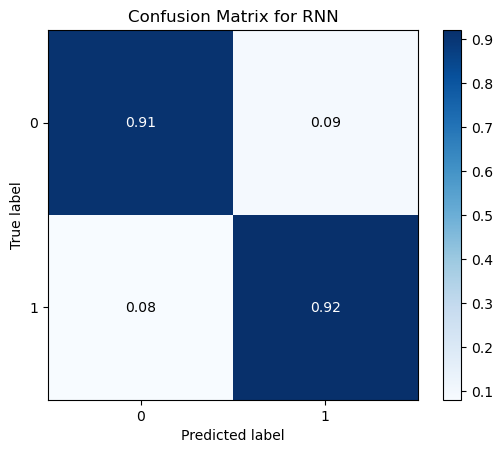

In [92]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(test_y, y_test_pred, normalize=True, title = 'Confusion Matrix for RNN')

## **Precision-Recall Curve**

<Axes: title={'center': 'PR Curve for RNN'}, xlabel='Recall', ylabel='Precision'>

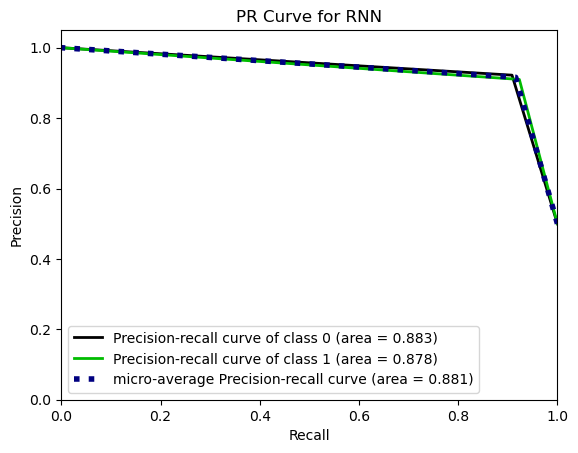

In [93]:
# Reshape y_test_pred to match the expected shape
y_probas = np.hstack((1 - y_test_pred, y_test_pred))

# Plot the precision-recall curve
skplt.metrics.plot_precision_recall(test_y, y_probas, title='PR Curve for RNN')

## **Feature Importance**

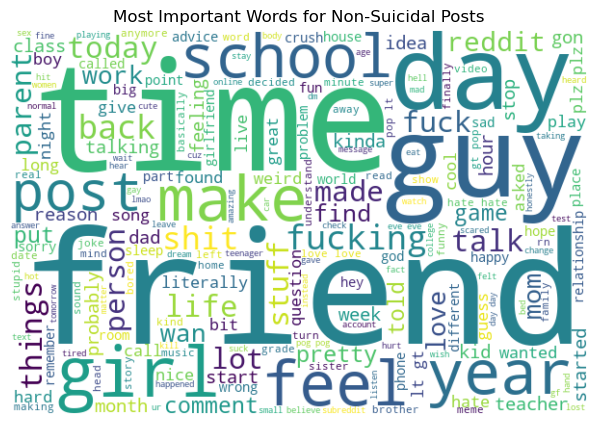

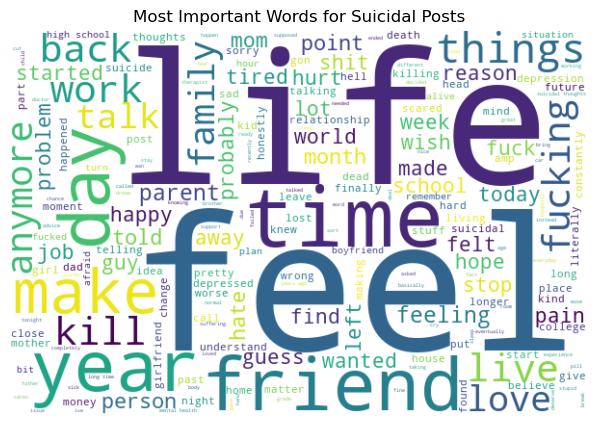

In [94]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the indices of samples for each class
class_indices = {
    0: np.where(y_test_pred == 0)[0],  # Negative class (non-suicidal)
    1: np.where(y_test_pred == 1)[0]   # Positive class (suicidal)
}

# Define a function to extract important words associated with each class
def extract_important_words(class_idx, num_words=50):
    indices = class_indices[class_idx]
    important_words = []

    for idx in indices:
        words = test_X_tokenized[idx]
        important_words.extend(words)

    return important_words

# Generate word clouds for each class
for class_idx in class_indices.keys():
    words = extract_important_words(class_idx)
    
    # Create a string from the extracted words
    words_string = ' '.join(words)
    
    # Generate the word cloud
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(words_string)
    
    class_name = "Suicidal" if class_idx == 1 else "Non-Suicidal"
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Important Words for {class_name} Posts')
    plt.axis('off')
    plt.show()

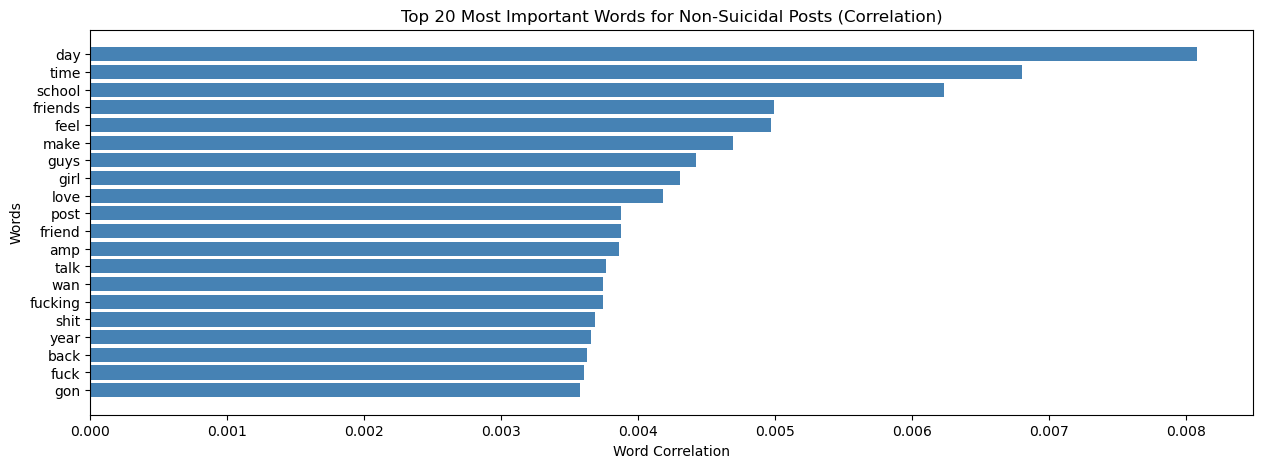

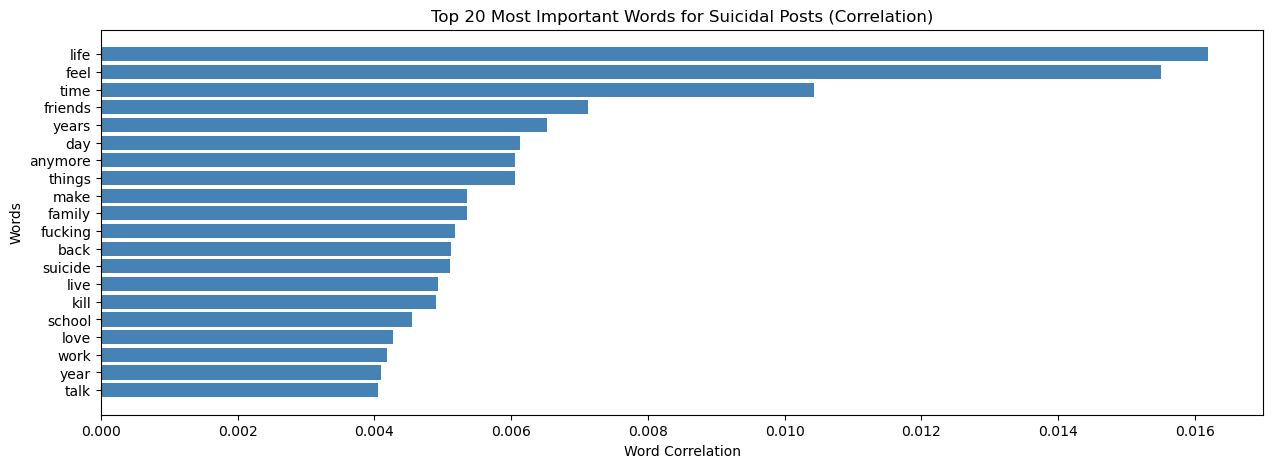

In [96]:
# Set the desired number of top words
num_words = 20

# Create a horizontal bar chart for each class
for class_idx in class_indices.keys():
    words = extract_important_words(class_idx, num_words)
    
    # Count the frequency of each word
    word_counts = {word: words.count(word) for word in set(words)}
    
    # Sort words by frequency in descending order
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Calculate total word occurrences
    total_occurrences = sum([word[1] for word in sorted_words])
    
    # Extract top words and their normalized frequencies (correlation values)
    top_words = [word[0] for word in sorted_words[:num_words]]
    top_word_correlations = [word[1] / total_occurrences for word in sorted_words[:num_words]]
    
    # Create the horizontal bar chart
    plt.figure(figsize=(15, 5))
    plt.barh(top_words, top_word_correlations, color='steelblue')
    plt.xlabel('Word Correlation')
    plt.ylabel('Words')
    class_name = "Suicidal" if class_idx == 1 else "Non-Suicidal"
    plt.title(f'Top {num_words} Most Important Words for {class_name} Posts (Correlation)')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most correlated word on top
    plt.show()

## **Sample Predictions**

In [27]:
# Choose a few samples for prediction display
num_samples_to_display = 5

# Select random indices for the chosen samples
sample_indices = np.random.choice(len(test_X), num_samples_to_display, replace=False)

# Make predictions for the chosen samples
sample_texts = [test_X[i] for i in sample_indices]
sample_true_labels = [test_y[i] for i in sample_indices]
sample_predicted_scores = model.predict(X_test_word_average[sample_indices], batch_size=32)
sample_predicted_labels = (sample_predicted_scores > 0.5).astype(int)

# Decode the label predictions using the LabelEncoder
sample_predicted_labels = le.inverse_transform(sample_predicted_labels)

# Display the sample predictions
for i in range(num_samples_to_display):
    print("Sample Text:", sample_texts[i])
    print("True Label:", sample_true_labels[i])
    print("Predicted Label:", sample_predicted_labels[i])
    print("Predicted Score:", sample_predicted_scores[i][0])  # Probability of positive class
    print("-" * 30)

1/1 [==============================] - 0s 13ms/step
Sample Text: making money years make money buy atv guys ideas make money made money teenager
True Label: 0
Predicted Label: 0
Predicted Score: 0.008550045
------------------------------
Sample Text: guys finally usb cord st guys tryna school st time
True Label: 0
Predicted Label: 0
Predicted Score: 0.07471929
------------------------------
Sample Text: happy years ago full illnesses cope anymore draining tiring life deal easy
True Label: 1
Predicted Label: 1
Predicted Score: 0.9857928
------------------------------
Sample Text: bid thee farewelli appreciate support ultimately vein life method note written blame decision sleepless nights easy ultimately reality things grateful greats goodbye
True Label: 1
Predicted Label: 1
Predicted Score: 0.9710689
------------------------------
Sample Text: poem wrote suicidal influences open meanings interest poetry fact lowest forms literature expression events recent past lead writing poem writte

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
